In [3]:
cd ..

/content/drive/MyDrive/freelancing/melanoma-skin-cancer-classifier


In [2]:
cd /content/drive/MyDrive/freelancing/melanoma-skin-cancer-classifier/skin cancer

/content/drive/MyDrive/freelancing/melanoma-skin-cancer-classifier/skin cancer


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf


In [16]:
import zipfile
import os

# Path to the zip file and extraction location
zip_path = "../melanoma-skin-cancer-classifier/skin cancer dataset.zip"  # Update with your actual path
extract_path = "../melanoma-skin-cancer-classifier/melanoma-skin-cancer-dataset-of-10000-images"  # Define extraction path

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to {extract_path}")


Dataset extracted to /content/drive/MyDrive/freelancing/melanoma-skin-cancer-classifier/melanoma-skin-cancer-dataset-of-10000-images


In [19]:
# Define dataset paths
dataset_path = "/../melanoma-skin-cancer-classifier/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset"
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'test')


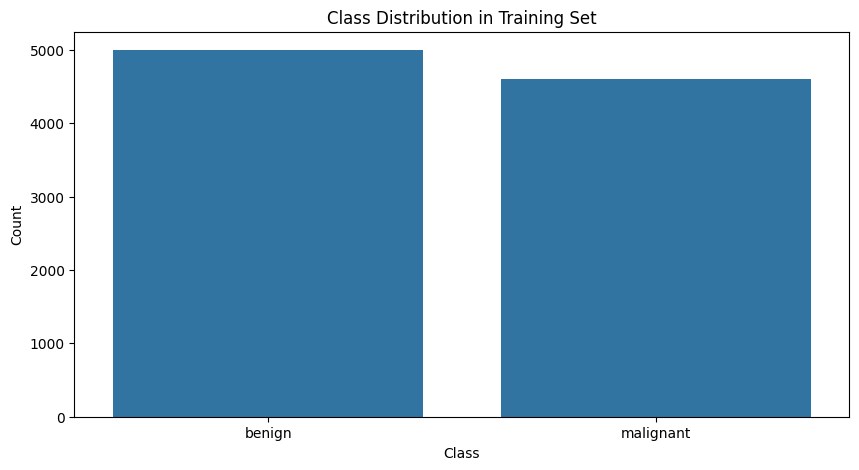

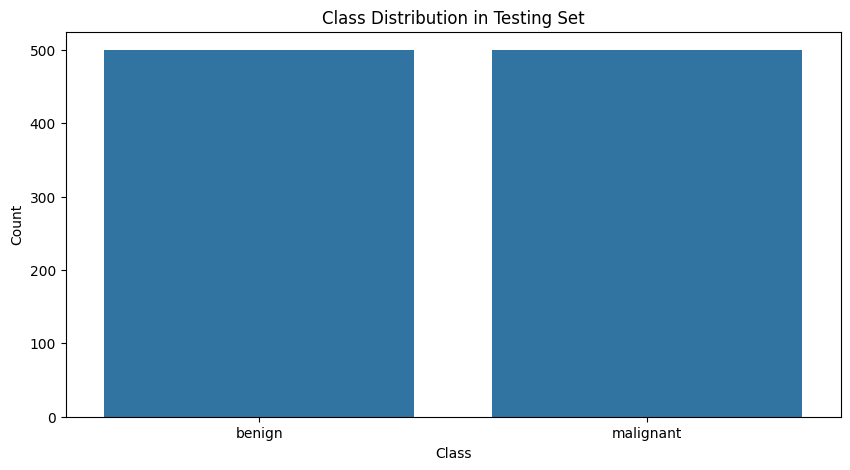

In [53]:
# Step 1: Exploratory Data Analysis (EDA)

# Count number of images per class in train and test
def count_images_in_directory(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images_in_directory(train_dir)
val_counts = count_images_in_directory(val_dir)

# Visualize the data distribution
train_df = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Count'])
val_df = pd.DataFrame(list(val_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Count', data=train_df)
plt.title('Class Distribution in Training Set')
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Count', data=val_df)
plt.title('Class Distribution in Testing Set')
plt.show()


In [21]:
# Step 2: Data Preprocessing
image_size = (224, 224)  # Standard size for VGG19 and EfficientNet
batch_size = 32

data_gen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, vertical_flip=True, zoom_range=0.2)

train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

val_generator = data_gen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')


Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Display Both Benign and Malignant Images in Color

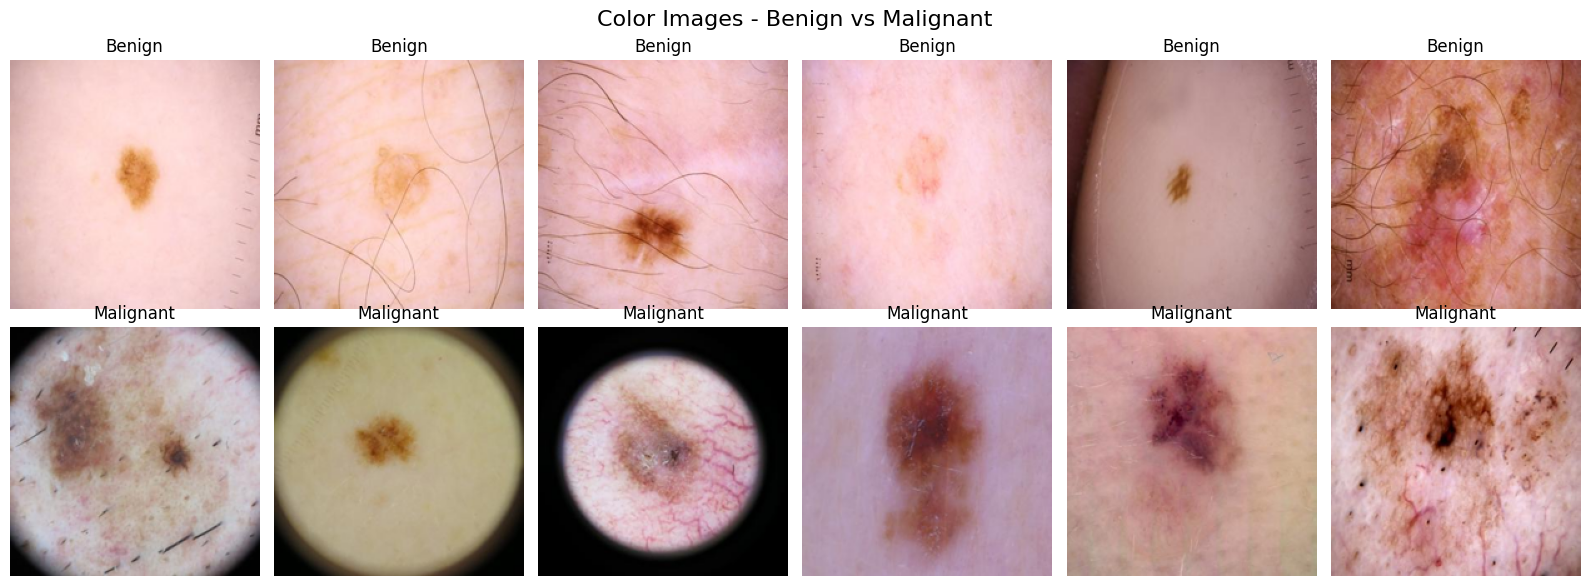

In [30]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Function to display benign and malignant images side by side
def display_color_images(benign_paths, malignant_paths, nrows=2, ncols=6, title="Benign and Malignant Images"):
    """
    Display benign and malignant images side by side in color.

    Parameters:
    - benign_paths: List of file paths to benign images.
    - malignant_paths: List of file paths to malignant images.
    - nrows: Number of rows in the grid.
    - ncols: Number of columns in the grid.
    - title: Title of the visualization.
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))
    plt.suptitle(title, fontsize=16)

    # Combine both lists
    combined_paths = benign_paths[:ncols] + malignant_paths[:ncols]  # Take `ncols` from each class

    for i, path in enumerate(combined_paths):
        if i >= nrows * ncols:
            break  # Stop if more images than grid slots

        # Read the image using PIL
        image = Image.open(path).resize((200, 200))  # Resize to 200x200 pixels

        # Determine subplot position
        x = i // ncols
        y = i % ncols
        axes[x, y].imshow(image)
        axes[x, y].axis('off')

        # Add a title to distinguish classes
        if i < ncols:
            axes[x, y].set_title("Benign")
        else:
            axes[x, y].set_title("Malignant")

    plt.tight_layout()
    plt.show()

# Example Usage
# Define directories for benign and malignant images
benign_dir = os.path.join(train_dir, 'benign')
malignant_dir = os.path.join(train_dir, 'malignant')

# Get a list of image paths for each class
benign_paths = [os.path.join(benign_dir, img) for img in os.listdir(benign_dir) if img.endswith(('.jpg', '.png'))]
malignant_paths = [os.path.join(malignant_dir, img) for img in os.listdir(malignant_dir) if img.endswith(('.jpg', '.png'))]

# Display benign and malignant images side by side
display_color_images(benign_paths, malignant_paths, nrows=2, ncols=6, title="Color Images - Benign vs Malignant")


Display Both Benign and Malignant Images in Grayscale

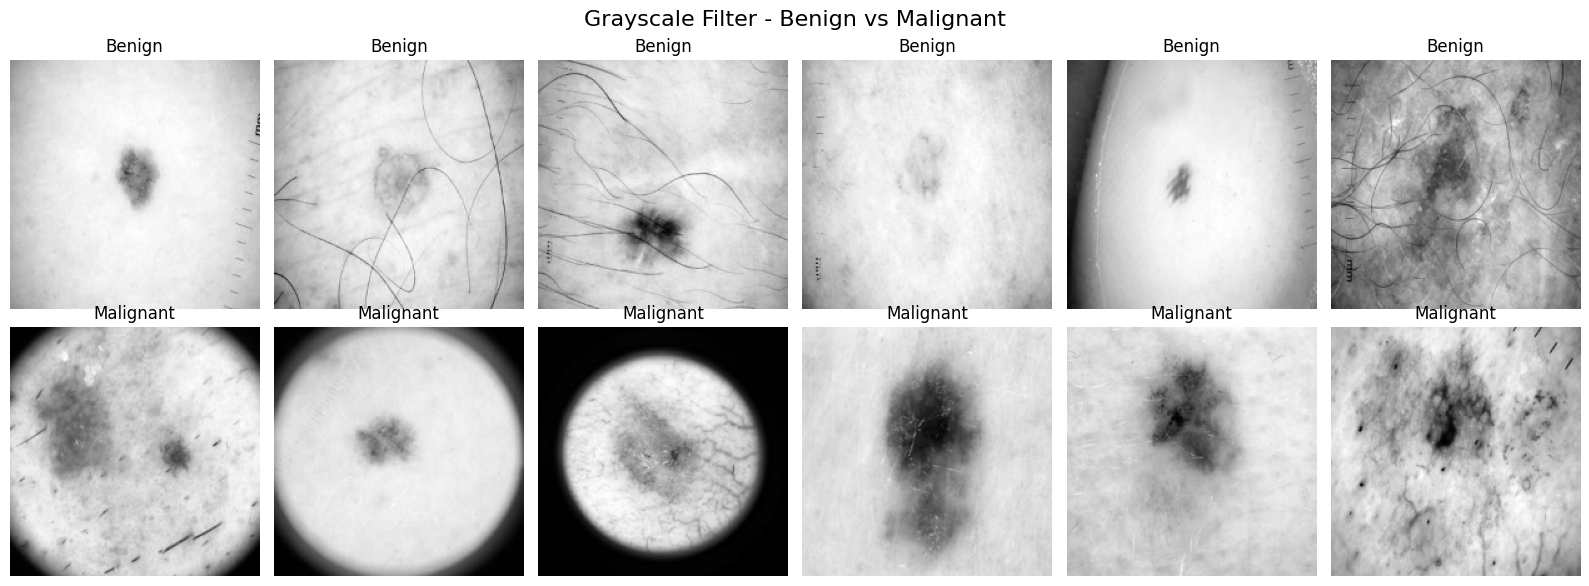

In [29]:
import matplotlib.pyplot as plt
import cv2
import os

# Function to display images with a grayscale filter applied
def display_benign_malignant_images(benign_paths, malignant_paths, nrows=2, ncols=6, title="Benign and Malignant Images"):
    """
    Apply a grayscale filter to benign and malignant images and display them.

    Parameters:
    - benign_paths: List of file paths to benign images.
    - malignant_paths: List of file paths to malignant images.
    - nrows: Number of rows in the grid.
    - ncols: Number of columns in the grid.
    - title: Title of the visualization.
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))
    plt.suptitle(title, fontsize=16)

    # Combine both lists
    combined_paths = benign_paths[:ncols] + malignant_paths[:ncols]  # Take `ncols` from each class

    for i, path in enumerate(combined_paths):
        if i >= nrows * ncols:
            break  # Stop if more images than grid slots

        # Read and preprocess the image
        image = cv2.imread(path)  # Read the image as a NumPy array
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        image = cv2.resize(image, (200, 200))  # Resize to 200x200 pixels

        # Determine subplot position
        x = i // ncols
        y = i % ncols
        axes[x, y].imshow(image, cmap=plt.cm.gray)
        axes[x, y].axis('off')

        # Add a title to distinguish classes
        if i < ncols:
            axes[x, y].set_title("Benign")
        else:
            axes[x, y].set_title("Malignant")

    plt.tight_layout()
    plt.show()

# Example Usage
# Define directories for benign and malignant images
benign_dir = os.path.join(train_dir, 'benign')
malignant_dir = os.path.join(train_dir, 'malignant')

# Get a list of image paths for each class
benign_paths = [os.path.join(benign_dir, img) for img in os.listdir(benign_dir) if img.endswith(('.jpg', '.png'))]
malignant_paths = [os.path.join(malignant_dir, img) for img in os.listdir(malignant_dir) if img.endswith(('.jpg', '.png'))]

# Display benign and malignant images side by side
display_benign_malignant_images(benign_paths, malignant_paths, nrows=2, ncols=6, title="Grayscale Filter - Benign vs Malignant")


Ben Graham Technique for Standard Images

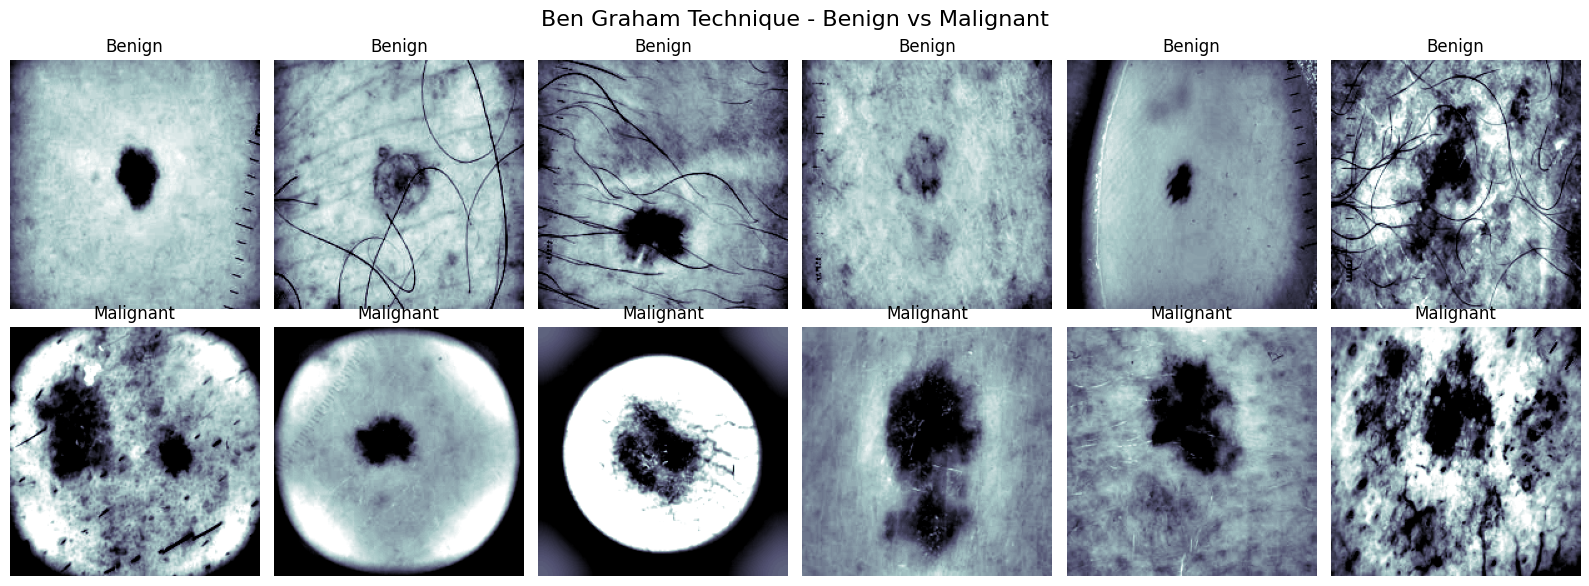

In [32]:
import matplotlib.pyplot as plt
import cv2
import os

# Function to apply Ben Graham preprocessing and display images
def display_ben_graham_images(benign_paths, malignant_paths, nrows=2, ncols=6, title="Ben Graham Technique - Benign vs Malignant"):
    """
    Apply Ben Graham Technique (Grayscale + Gaussian Blur) to benign and malignant images.

    Parameters:
    - benign_paths: List of file paths to benign images.
    - malignant_paths: List of file paths to malignant images.
    - nrows: Number of rows in the grid.
    - ncols: Number of columns in the grid.
    - title: Title of the visualization.
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))
    plt.suptitle(title, fontsize=16)

    # Combine both lists
    combined_paths = benign_paths[:ncols] + malignant_paths[:ncols]  # Take `ncols` images from each class

    for i, path in enumerate(combined_paths):
        if i >= nrows * ncols:
            break  # Avoid index-out-of-range errors

        # Read the image
        image = cv2.imread(path)  # Read the image as a NumPy array
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        image = cv2.resize(image, (200, 200))  # Resize to 200x200 pixels

        # Apply Gaussian blur and enhance
        image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), 256 / 10), -4, 128)

        # Determine subplot position
        x = i // ncols
        y = i % ncols
        axes[x, y].imshow(image, cmap=plt.cm.bone)
        axes[x, y].axis('off')

        # Add title to distinguish classes
        if i < ncols:
            axes[x, y].set_title("Benign")
        else:
            axes[x, y].set_title("Malignant")

    plt.tight_layout()
    plt.show()

# Example Usage
# Define directories for benign and malignant images
benign_dir = os.path.join(train_dir, 'benign')
malignant_dir = os.path.join(train_dir, 'malignant')

# Get a list of image paths for each class
benign_paths = [os.path.join(benign_dir, img) for img in os.listdir(benign_dir) if img.endswith(('.jpg', '.png'))]
malignant_paths = [os.path.join(malignant_dir, img) for img in os.listdir(malignant_dir) if img.endswith(('.jpg', '.png'))]

# Apply Ben Graham Technique and display images
display_ben_graham_images(benign_paths, malignant_paths, nrows=2, ncols=6, title="Ben Graham Technique - Benign vs Malignant")


HSV Transformation for Both Benign and Malignant Images

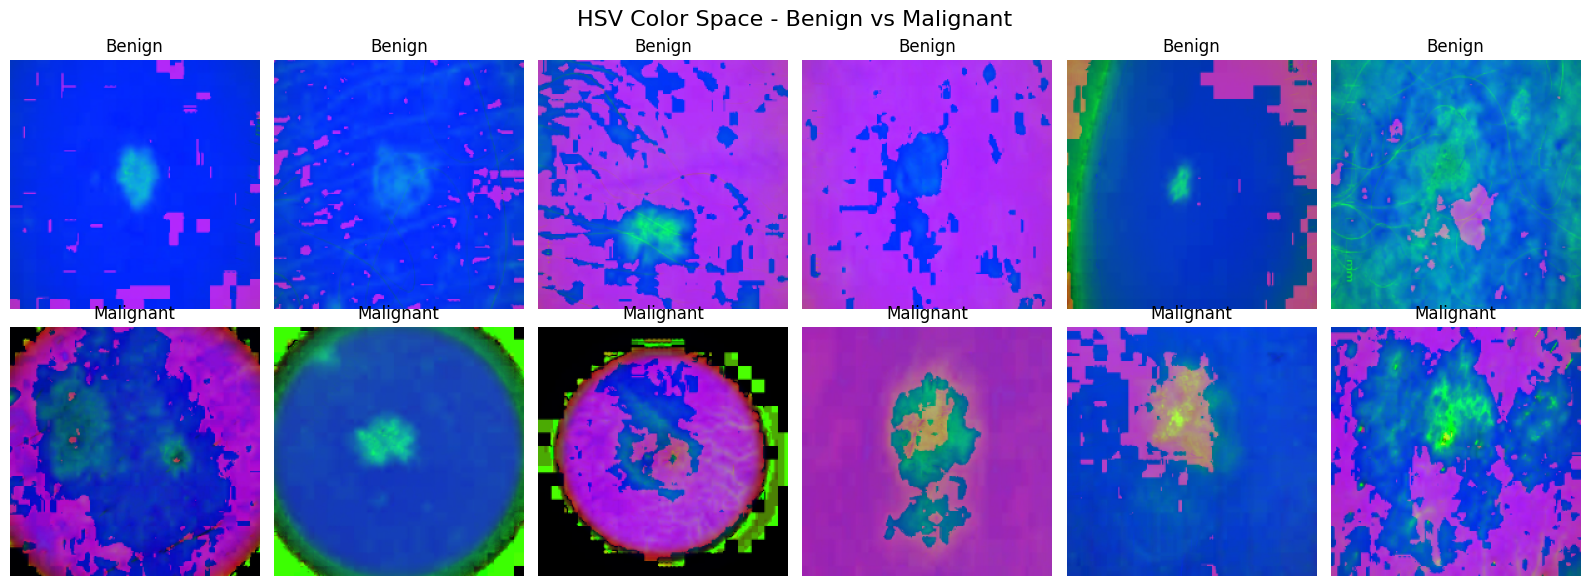

In [33]:
import matplotlib.pyplot as plt
import cv2
import os

# Function to apply HSV transformation and display images
def display_hsv_images(benign_paths, malignant_paths, nrows=2, ncols=6, title="HSV Color Space - Benign vs Malignant"):
    """
    Convert images to HSV color space and display benign and malignant images side by side.

    Parameters:
    - benign_paths: List of file paths to benign images.
    - malignant_paths: List of file paths to malignant images.
    - nrows: Number of rows in the grid.
    - ncols: Number of columns in the grid.
    - title: Title of the visualization.
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))
    plt.suptitle(title, fontsize=16)

    # Combine both lists
    combined_paths = benign_paths[:ncols] + malignant_paths[:ncols]  # Take `ncols` images from each class

    for i, path in enumerate(combined_paths):
        if i >= nrows * ncols:
            break  # Avoid index-out-of-range errors

        # Read the image
        image = cv2.imread(path)  # Read the image as a NumPy array
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # Convert to HSV color space
        image = cv2.resize(image, (200, 200))  # Resize to 200x200 pixels

        # Determine subplot position
        x = i // ncols
        y = i % ncols
        axes[x, y].imshow(image)
        axes[x, y].axis('off')

        # Add title to distinguish classes
        if i < ncols:
            axes[x, y].set_title("Benign")
        else:
            axes[x, y].set_title("Malignant")

    plt.tight_layout()
    plt.show()

# Example Usage
# Define directories for benign and malignant images
benign_dir = os.path.join(train_dir, 'benign')
malignant_dir = os.path.join(train_dir, 'malignant')

# Get a list of image paths for each class
benign_paths = [os.path.join(benign_dir, img) for img in os.listdir(benign_dir) if img.endswith(('.jpg', '.png'))]
malignant_paths = [os.path.join(malignant_dir, img) for img in os.listdir(malignant_dir) if img.endswith(('.jpg', '.png'))]

# Apply HSV Transformation and display images
display_hsv_images(benign_paths, malignant_paths, nrows=2, ncols=6, title="HSV Color Space - Benign vs Malignant")


HLS Transformation for Both Benign and Malignant Images

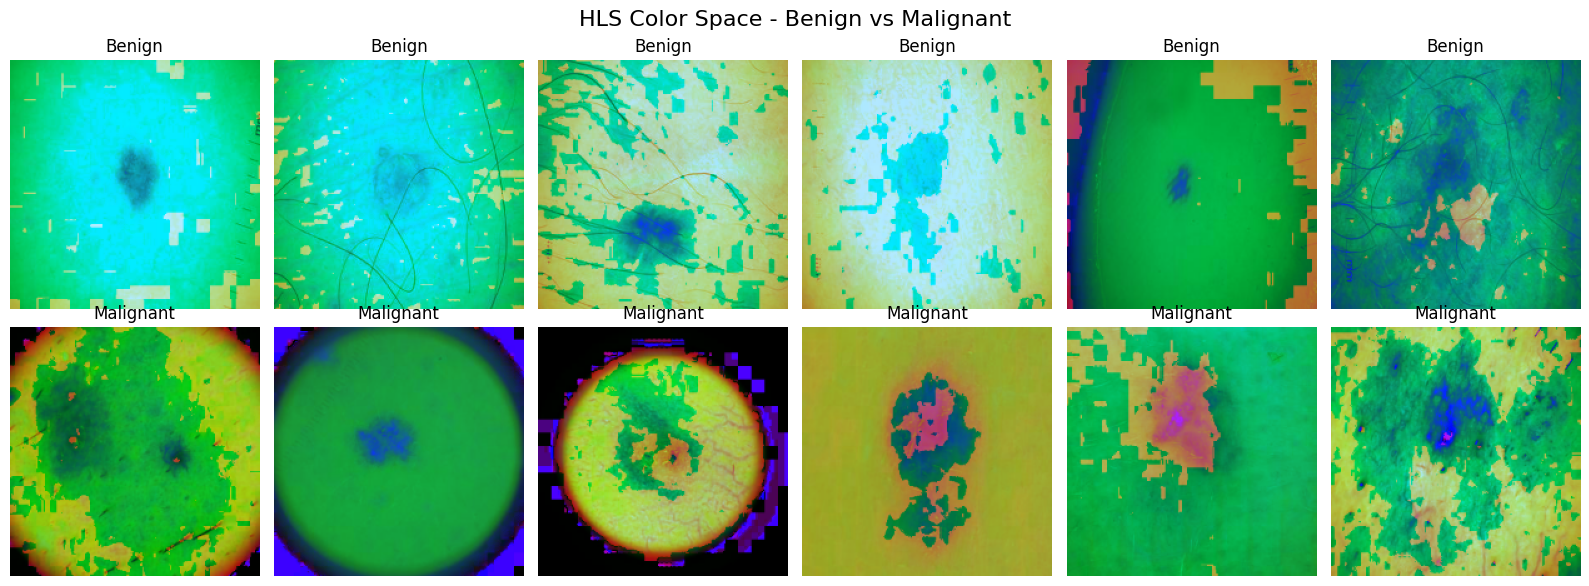

In [34]:
import matplotlib.pyplot as plt
import cv2
import os

# Function to apply HLS transformation and display images
def display_hls_images(benign_paths, malignant_paths, nrows=2, ncols=6, title="HLS Color Space - Benign vs Malignant"):
    """
    Convert images to HLS color space and display benign and malignant images side by side.

    Parameters:
    - benign_paths: List of file paths to benign images.
    - malignant_paths: List of file paths to malignant images.
    - nrows: Number of rows in the grid.
    - ncols: Number of columns in the grid.
    - title: Title of the visualization.
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))
    plt.suptitle(title, fontsize=16)

    # Combine both lists
    combined_paths = benign_paths[:ncols] + malignant_paths[:ncols]  # Take `ncols` images from each class

    for i, path in enumerate(combined_paths):
        if i >= nrows * ncols:
            break  # Avoid index-out-of-range errors

        # Read the image
        image = cv2.imread(path)  # Read the image as a NumPy array
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)  # Convert to HLS color space
        image = cv2.resize(image, (200, 200))  # Resize to 200x200 pixels

        # Determine subplot position
        x = i // ncols
        y = i % ncols
        axes[x, y].imshow(image)
        axes[x, y].axis('off')

        # Add title to distinguish classes
        if i < ncols:
            axes[x, y].set_title("Benign")
        else:
            axes[x, y].set_title("Malignant")

    plt.tight_layout()
    plt.show()

# Example Usage
# Define directories for benign and malignant images
benign_dir = os.path.join(train_dir, 'benign')
malignant_dir = os.path.join(train_dir, 'malignant')

# Get a list of image paths for each class
benign_paths = [os.path.join(benign_dir, img) for img in os.listdir(benign_dir) if img.endswith(('.jpg', '.png'))]
malignant_paths = [os.path.join(malignant_dir, img) for img in os.listdir(malignant_dir) if img.endswith(('.jpg', '.png'))]

# Apply HLS Transformation and display images
display_hls_images(benign_paths, malignant_paths, nrows=2, ncols=6, title="HLS Color Space - Benign vs Malignant")


LUV Transformation for Both Benign and Malignant Images

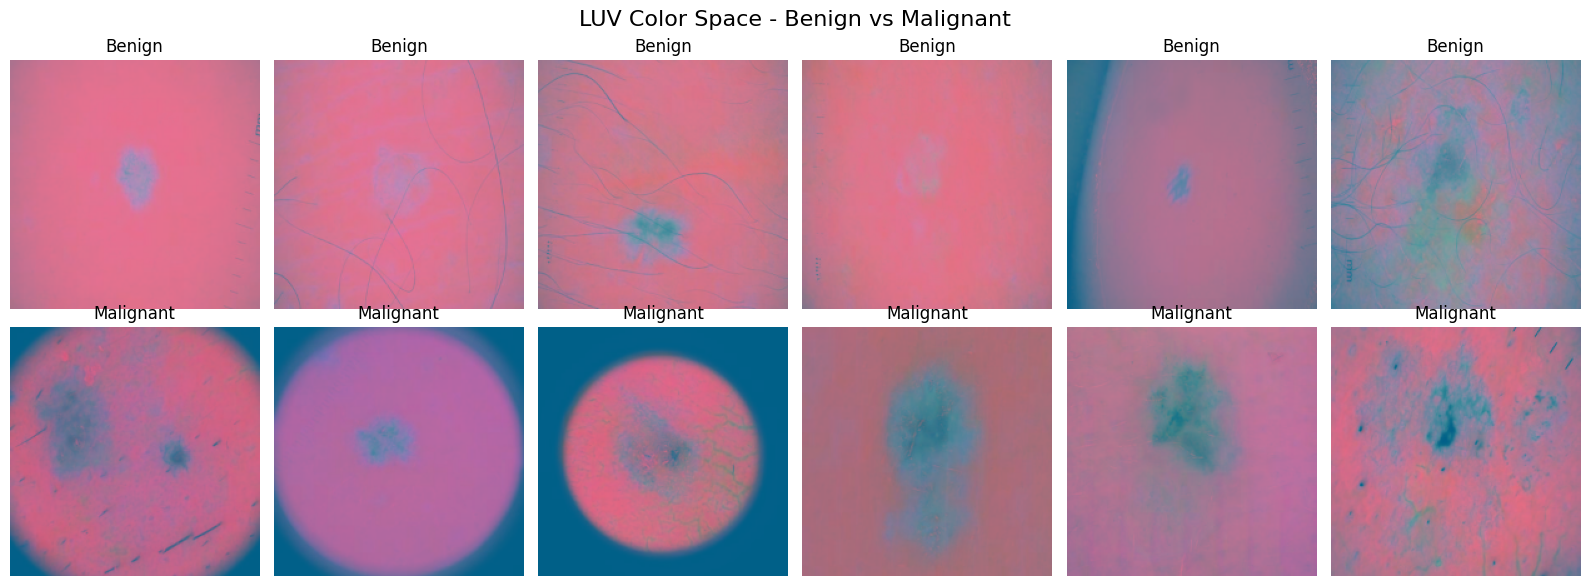

In [35]:
import matplotlib.pyplot as plt
import cv2
import os

# Function to apply LUV transformation and display images
def display_luv_images(benign_paths, malignant_paths, nrows=2, ncols=6, title="LUV Color Space - Benign vs Malignant"):
    """
    Convert images to LUV color space and display benign and malignant images side by side.

    Parameters:
    - benign_paths: List of file paths to benign images.
    - malignant_paths: List of file paths to malignant images.
    - nrows: Number of rows in the grid.
    - ncols: Number of columns in the grid.
    - title: Title of the visualization.
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))
    plt.suptitle(title, fontsize=16)

    # Combine both lists
    combined_paths = benign_paths[:ncols] + malignant_paths[:ncols]  # Take `ncols` images from each class

    for i, path in enumerate(combined_paths):
        if i >= nrows * ncols:
            break  # Avoid index-out-of-range errors

        # Read the image
        image = cv2.imread(path)  # Read the image as a NumPy array
        image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)  # Convert to LUV color space
        image = cv2.resize(image, (200, 200))  # Resize to 200x200 pixels

        # Determine subplot position
        x = i // ncols
        y = i % ncols
        axes[x, y].imshow(image)
        axes[x, y].axis('off')

        # Add title to distinguish classes
        if i < ncols:
            axes[x, y].set_title("Benign")
        else:
            axes[x, y].set_title("Malignant")

    plt.tight_layout()
    plt.show()

# Example Usage
# Define directories for benign and malignant images
benign_dir = os.path.join(train_dir, 'benign')
malignant_dir = os.path.join(train_dir, 'malignant')

# Get a list of image paths for each class
benign_paths = [os.path.join(benign_dir, img) for img in os.listdir(benign_dir) if img.endswith(('.jpg', '.png'))]
malignant_paths = [os.path.join(malignant_dir, img) for img in os.listdir(malignant_dir) if img.endswith(('.jpg', '.png'))]

# Apply LUV Transformation and display images
display_luv_images(benign_paths, malignant_paths, nrows=2, ncols=6, title="LUV Color Space - Benign vs Malignant")


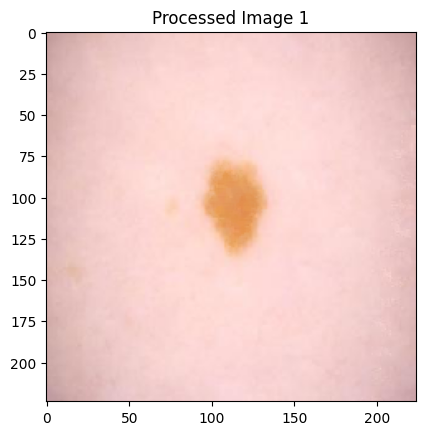

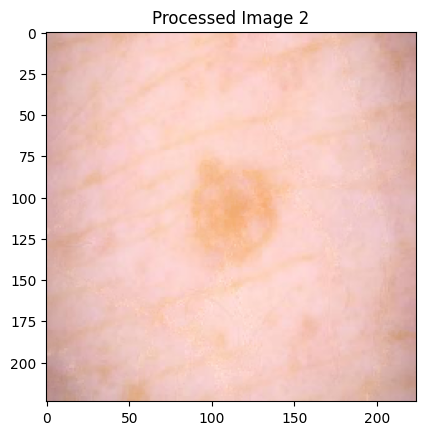

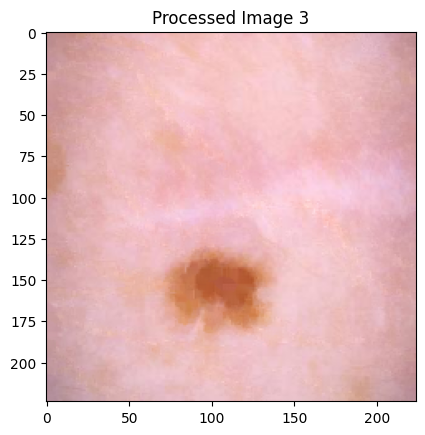

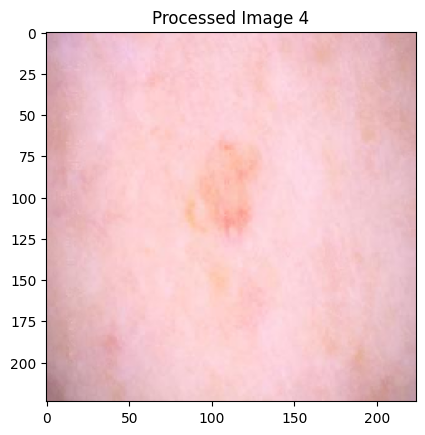

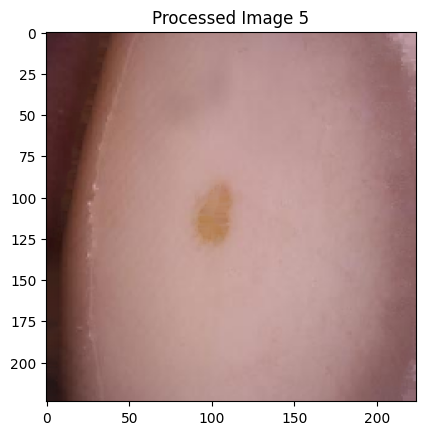

In [50]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image


def hair_remove(img):
    # Kernel for morphologyEx
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))

    # Apply MORPH_BLACKHAT to image
    blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)

    # Apply thresholding to blackhat, ensuring a single-channel mask
    _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    # Ensure threshold is a single-channel image (grayscale) and has dtype uint8
    threshold = threshold[:, :, 0].astype(np.uint8) # Convert to single-channel and ensure dtype is uint8

    # Ensure img is in the correct data type: uint8 with 3 channels
    img = img.astype(np.uint8)

    # Inpaint with the original image and threshold image
    final_image = cv2.inpaint(img, threshold, 1, cv2.INPAINT_TELEA)

    return final_image

# Function to load and preprocess images from directory
def load_and_preprocess_images(dir_path, target_size=(224, 224)):
    processed_images = []
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            img_path = os.path.join(root, file)
            img = image.load_img(img_path, target_size=target_size)  # Load image with target size
            img_array = image.img_to_array(img)  # Convert to array
            processed_img = hair_remove(img_array)  # Apply hair removal
            processed_images.append(processed_img)
    return np.array(processed_images)

# Load and process training images
train_images_processed = load_and_preprocess_images(train_dir)

# Load and process validation images
val_images_processed = load_and_preprocess_images(val_dir)

# Optionally, save the processed images if needed
# Example: Save processed images to a directory
# np.save('/path_to_save/train_images_processed.npy', train_images_processed)
# np.save('/path_to_save/val_images_processed.npy', val_images_processed)

# To visualize a few processed images (optional)
import matplotlib.pyplot as plt

# Display example of processed images
for i in range(5):  # Display first 5 processed images from training set
    plt.imshow(train_images_processed[i].astype(np.uint8))
    plt.title(f"Processed Image {i + 1}")
    plt.show()


In [51]:
# Step 3: Model Building
num_classes = len(train_generator.class_indices)

# VGG19 Model
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=image_size + (3,))
vgg19_base.trainable = False

vgg19_model = Model(
    inputs=vgg19_base.input,
    outputs=Dense(num_classes, activation='softmax')(Flatten()(vgg19_base.output))
)

vgg19_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])




In [52]:
# EfficientNetB7 Model
efficientnet_base = EfficientNetB7(weights='imagenet', include_top=False, input_shape=image_size + (3,))
efficientnet_base.trainable = False

efficientnet_model = Model(
    inputs=efficientnet_base.input,
    outputs=Dense(num_classes, activation='softmax')(GlobalAveragePooling2D()(efficientnet_base.output))
)

efficientnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Step 4: Model Training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)


In [26]:
# Train VGG19 Model
vgg19_history = vgg19_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


267/301 ━━━━━━━━━━━━━━━━━━━━ 18s 559ms/step - accuracy: 0.7179 - loss: 0.5121

KeyboardInterrupt: 

In [ ]:
# Train EfficientNetB7 Model
efficientnet_history = efficientnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stopping, reduce_lr]
)



In [ ]:
# Step 5: Model Evaluation
vgg19_eval = vgg19_model.evaluate(val_generator)
efficientnet_eval = efficientnet_model.evaluate(val_generator)

print("VGG19 Evaluation - Loss: {:.4f}, Accuracy: {:.4f}".format(vgg19_eval[0], vgg19_eval[1]))
print("EfficientNetB7 Evaluation - Loss: {:.4f}, Accuracy: {:.4f}".format(efficientnet_eval[0], efficientnet_eval[1]))

# Confusion Matrix and Classification Report for VGG19
val_generator.reset()
predictions_vgg19 = np.argmax(vgg19_model.predict(val_generator), axis=1)
true_labels = val_generator.classes

print("Classification Report for VGG19")
print(classification_report(true_labels, predictions_vgg19, target_names=list(val_generator.class_indices.keys())))

cm_vgg19 = confusion_matrix(true_labels, predictions_vgg19)
sns.heatmap(cm_vgg19, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title("Confusion Matrix - VGG19")
plt.show()



In [ ]:
# Confusion Matrix and Classification Report for EfficientNetB7
val_generator.reset()
predictions_eff = np.argmax(efficientnet_model.predict(val_generator), axis=1)

print("Classification Report for EfficientNetB7")
print(classification_report(true_labels, predictions_eff, target_names=list(val_generator.class_indices.keys())))

cm_eff = confusion_matrix(true_labels, predictions_eff)
sns.heatmap(cm_eff, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title("Confusion Matrix - EfficientNetB7")
plt.show()

# Step 6: Visualize Training History
def plot_training_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy/Loss')
    plt.show()

plot_training_history(vgg19_history, 'VGG19 Training History')
plot_training_history(efficientnet_history, 'EfficientNetB7 Training History')
